In [4]:
import pandas as pd
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis.gensim 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.feature_extraction import text 

warnings.simplefilter("ignore", DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### Topic Model with Animation

### Step 1: Load first file and process

In [24]:
# Load first file 
# Randomly select 100 reviews from each movie after dropping reviews with less than 100 letters
reviews = pd.read_csv('../data/reviews_cleaned/Animation.csv')
reviews = reviews.dropna()
reviews = reviews[reviews.review_text.str.len() > 100]
reviews = reviews.sample(frac=1, random_state=1234).groupby('imdbId', sort=False).head(100)
reviews = reviews.drop(columns=['imdbId'], axis=1)

# Text processing
# Remove punctuation
reviews['review_processed'] = reviews['review_text'].map(lambda x: re.sub('[,\.!?:]|\\n', '', x))
# Convert the titles to lowercase
reviews['review_processed'] = reviews['review_processed'].map(lambda x: x.lower())

### Step 2: View Wordcloud

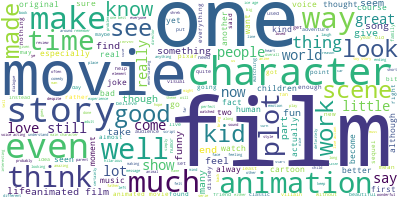

In [25]:
# Join the different processed titles together.
long_string = ','.join(list(reviews['review_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Step 3: Exploratory Analysis

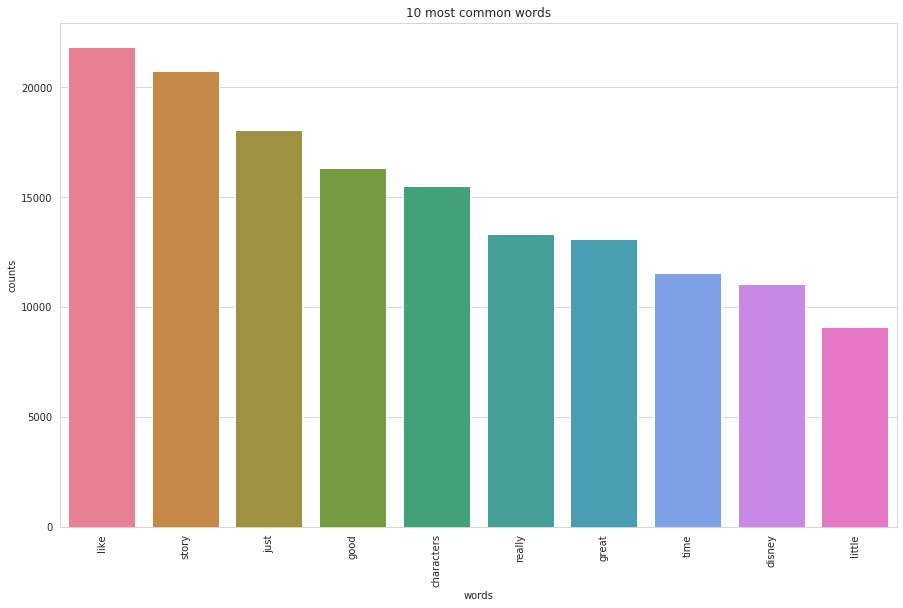

In [26]:
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(['films', 'film', 'movies', 'movie', 'animation', 'animated'])
count_vectorizer = CountVectorizer(stop_words= my_stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(reviews['review_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### Step 4: LDA Training and results visualization

In [34]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 15
number_words = 15
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
story pixar characters like cars just burton new life family good voice time great tim

Topic #1:
wars minions star despicable gru el easter dorado villain road steve clone like oh little

Topic #2:
disney story like christmas good great characters book music just best songs really classic time

Topic #3:
batman characters like lego best story christmas action great voice time monsters character looney fox

Topic #4:
father shrek like daughter story think scene life anastasia music man tati day paper time

Topic #5:
disney story love little great like princess songs characters best time beauty family good music

Topic #6:
life story world like way time art people war beautiful real just work love fantasy

Topic #7:
stop motion coraline man kubo rango sheep character paddington spider laika shaun children story town

Topic #8:
story fu toy kung panda voice po woody life character like characters great action pixar

Topic #9:
like just good kids really do

### Step 5: Exploratory LDA
Saving graphs to html

In [35]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
pyLDAvis.save_html(LDAvis_prepared, 'topic_model_animation.html')

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/jovyan/.rsm-msba/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Step 6: Plotting Bigram and Trigram